
🟢 Running K-Means Clustering...


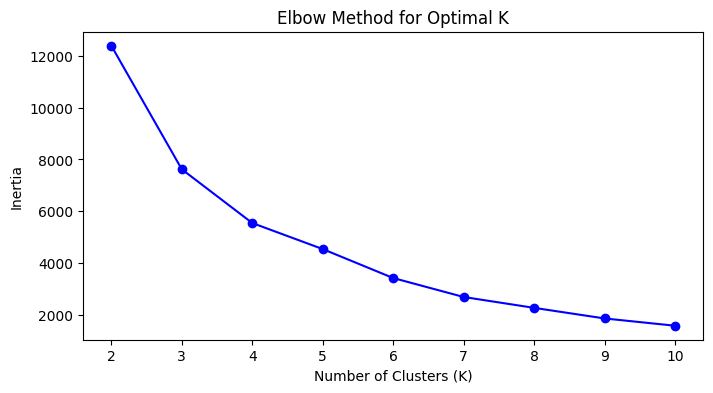

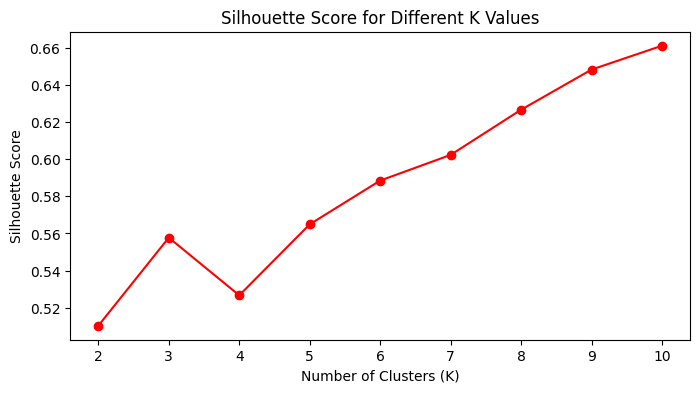


🔵 K-Means Clustering Evaluation:
                    Metric           K=4           K=5
0         Silhouette Score      0.526688      0.564915
1     Davies-Bouldin Index      0.701271      0.651172
2  Calinski-Harabasz Score  13252.169174  12801.270173

🟠 Running DBSCAN Clustering...


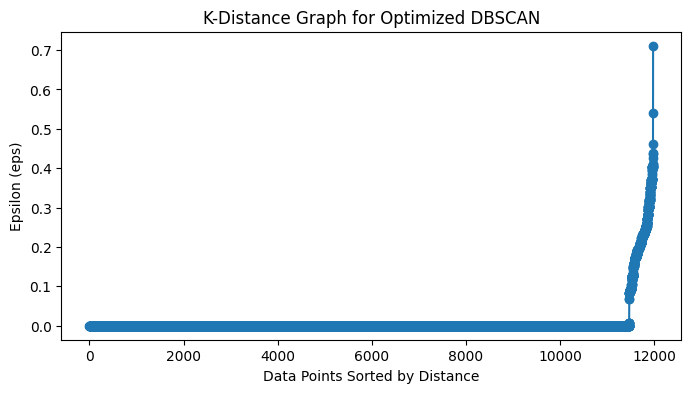


🟠 Best DBSCAN Parameters:
Epsilon: 0.4
Min Samples: 10
Silhouette Score: 0.2439
Davies-Bouldin Index: 0.4893
Calinski-Harabasz Score: 106.5797


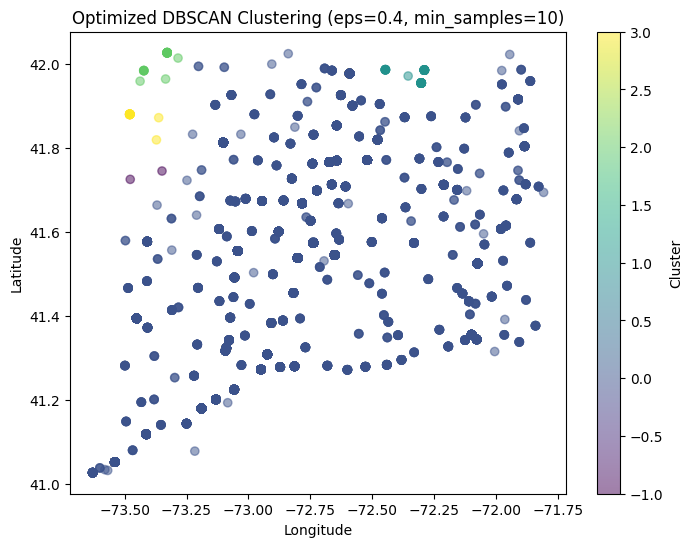

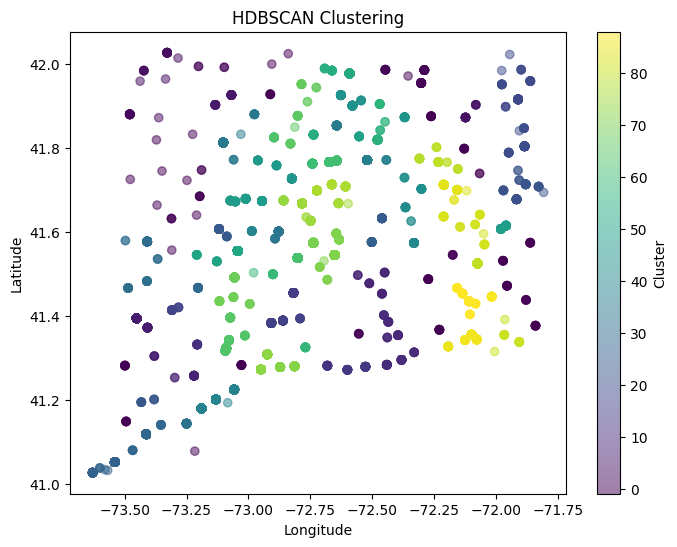


HDBSCAN Clustering Evaluation Results:
                        Metric   HDBSCAN
0             Silhouette Score  0.897464
1         Davies-Bouldin Index  0.372074
2  Mean Intra-Cluster Distance  0.051513

🟣 Generating Hierarchical Dendrogram...

⚠️ Large dataset detected (11981 samples). Truncating to 5000 samples for linkage computation.


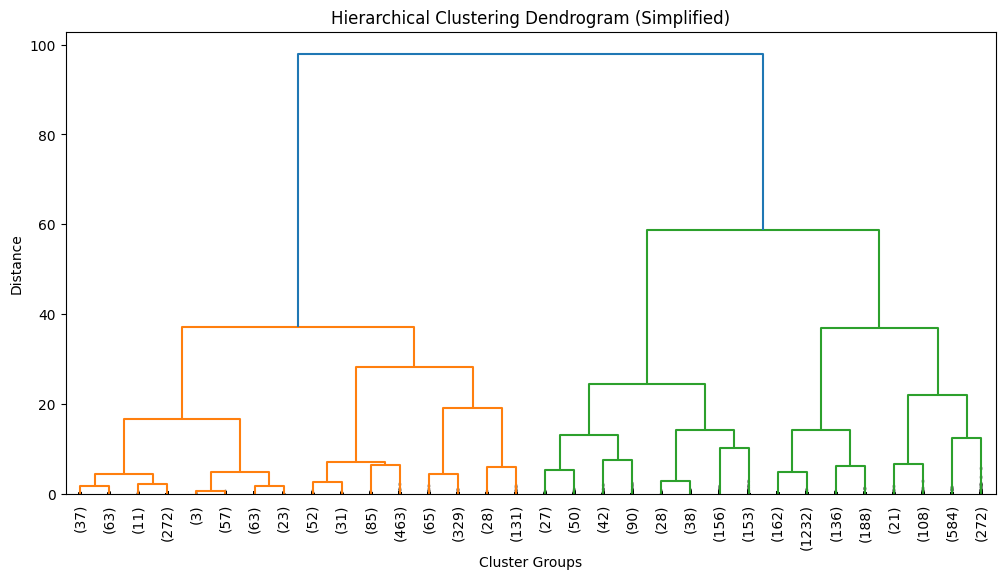

Stability Validation Results (Full Dataset)
                      Metric  K-Means  DBSCAN (Full Run)  HDBSCAN (Full Run)
0  ARI (Higher=More Stable)      1.0                1.0                 1.0
1  NMI (Higher=More Stable)      1.0                1.0                 1.0


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (silhouette_score, davies_bouldin_score, calinski_harabasz_score,
                             adjusted_rand_score, normalized_mutual_info_score)
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

file_path = "Accidental_Drug_Related_Deaths_Cleaned.csv"

# ---------- K-MEANS CLUSTERING -------------
print("\n🟢 Running K-Means Clustering...")

df = pd.read_csv(file_path)  # Reload data to ensure freshness
geo_data = df[['death_latitude', 'death_longitude']]
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)

# Determine optimal K using Elbow Method & Silhouette Scores
inertia, silhouette_scores = [], []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(geo_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(geo_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values')
plt.show()

# Apply K-Means clustering for optimal K=4 and K=5
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster_k4'] = kmeans_4.fit_predict(geo_scaled)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster_k5'] = kmeans_5.fit_predict(geo_scaled)

# Compute evaluation metrics
metrics = {
    "Metric": ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Score"],
    "K=4": [silhouette_score(geo_scaled, df['cluster_k4']), davies_bouldin_score(geo_scaled, df['cluster_k4']),
            calinski_harabasz_score(geo_scaled, df['cluster_k4'])],
    "K=5": [silhouette_score(geo_scaled, df['cluster_k5']), davies_bouldin_score(geo_scaled, df['cluster_k5']),
            calinski_harabasz_score(geo_scaled, df['cluster_k5'])]
}

print("\n🔵 K-Means Clustering Evaluation:")
evaluation_df = pd.DataFrame(metrics)
print(evaluation_df)

# ---------- RESET DATA FOR DBSCAN -------------
df = pd.read_csv(file_path)  # Reload original dataset
geo_data = df[['death_latitude', 'death_longitude']]
geo_scaled = scaler.fit_transform(geo_data)

print("\n🟠 Running DBSCAN Clustering...")

# 🔹 Step 1: Automatic eps selection using k-distance method
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(geo_scaled)
distances, indices = neighbors_fit.kneighbors(geo_scaled)

# 🔹 Sort distances and plot K-distance graph
distances = np.sort(distances[:, 9], axis=0)
plt.figure(figsize=(8, 4))
plt.plot(distances, marker='o', linestyle='-')
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel("Epsilon (eps)")
plt.title("K-Distance Graph for Optimized DBSCAN")
plt.show()

# 🔹 Step 2: Test multiple eps and min_samples values
eps_values = [0.4, 0.45, 0.5]  # Adjust based on k-distance graph
min_samples_values = [10, 12, 15]

best_score = -1
best_params = None

# Loop through all parameter combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        df['cluster_dbscan'] = dbscan.fit_predict(geo_scaled)

        # Mask for core samples (ignore noise)
        core_samples_mask = df['cluster_dbscan'] != -1

        # Ensure we have at least 2 clusters
        if len(set(df['cluster_dbscan'][core_samples_mask])) > 1:
            silhouette = silhouette_score(geo_scaled[core_samples_mask], df['cluster_dbscan'][core_samples_mask])
            davies_bouldin = davies_bouldin_score(geo_scaled[core_samples_mask], df['cluster_dbscan'][core_samples_mask])
            calinski_harabasz = calinski_harabasz_score(geo_scaled[core_samples_mask], df['cluster_dbscan'][core_samples_mask])

            # Track best performing parameters
            if silhouette > best_score:
                best_score = silhouette
                best_params = (eps, min_samples, silhouette, davies_bouldin, calinski_harabasz)

# 🔹 Step 3: Handle cases where no valid clusters were found
if best_params is None:
    print("\n⚠️ No valid clusters found for DBSCAN. Try different `eps` and `min_samples` values.")
else:
    best_eps, best_min_samples, best_silhouette, best_davies_bouldin, best_calinski_harabasz = best_params

    print("\n🟠 Best DBSCAN Parameters:")
    print(f"Epsilon: {best_eps}")
    print(f"Min Samples: {best_min_samples}")
    print(f"Silhouette Score: {best_silhouette:.4f}")
    print(f"Davies-Bouldin Index: {best_davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Score: {best_calinski_harabasz:.4f}")

    # 🔹 Step 4: Run DBSCAN with best parameters
    dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    df['cluster_dbscan'] = dbscan_best.fit_predict(geo_scaled)

    # 🔹 Step 5: Visualize Optimized DBSCAN Clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(df['death_longitude'], df['death_latitude'], c=df['cluster_dbscan'], cmap='viridis', alpha=0.5)
    plt.title(f"Optimized DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Cluster")
    plt.show()



# ---------- RESET DATA FOR HDBSCAN -------------
df = pd.read_csv(file_path)
# Extract relevant columns (death latitude & longitude)
geo_data = df[['death_latitude', 'death_longitude']]

# Standardize the data (important for clustering)
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)

# Step 1: Apply HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=0.2, gen_min_span_tree=True)
df['cluster_hdbscan'] = hdb.fit_predict(geo_scaled)

# Step 2: Visualize HDBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(df['death_longitude'], df['death_latitude'], c=df['cluster_hdbscan'], cmap='viridis', alpha=0.5)
plt.title("HDBSCAN Clustering")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.show()

# Step 3: Evaluate Clustering Performance (Without Calinski-Harabasz)
core_samples_mask = df['cluster_hdbscan'] != -1  # Ignore noise points (-1)

if len(set(df['cluster_hdbscan'][core_samples_mask])) > 1:
    silhouette_hdbscan = silhouette_score(geo_scaled[core_samples_mask], df['cluster_hdbscan'][core_samples_mask])
    davies_bouldin_hdbscan = davies_bouldin_score(geo_scaled[core_samples_mask],
                                                  df['cluster_hdbscan'][core_samples_mask])

    # New: Compute Mean Intra-Cluster Distance (Compactness Measure)
    cluster_distances = []
    for cluster in set(df['cluster_hdbscan'][core_samples_mask]):
        cluster_points = geo_scaled[df['cluster_hdbscan'] == cluster]
        if len(cluster_points) > 1:
            intra_distances = pdist(cluster_points)
            cluster_distances.append(np.mean(intra_distances))

    mean_intra_distance = np.mean(cluster_distances) if cluster_distances else np.nan
else:
    silhouette_hdbscan, davies_bouldin_hdbscan, mean_intra_distance = np.nan, np.nan, np.nan

# Display results
evaluation_results = pd.DataFrame({
    "Metric": ["Silhouette Score", "Davies-Bouldin Index", "Mean Intra-Cluster Distance"],
    "HDBSCAN": [silhouette_hdbscan, davies_bouldin_hdbscan, mean_intra_distance]
})

print("\nHDBSCAN Clustering Evaluation Results:")
print(evaluation_results)
# ---------- HIERARCHICAL DENDROGRAM -------------
# 🔵 Ensure geo_scaled has enough unique points
if len(np.unique(geo_scaled, axis=0)) < 2:
    print("\n⚠️ Not enough unique points to create a valid dendrogram. Skipping...")
else:
    print("\n🟣 Generating Hierarchical Dendrogram...")

    # 🔹 Compute hierarchical linkage safely (limit max samples for performance)
    max_samples = 5000  # Change this based on dataset size
    if len(geo_scaled) > max_samples:
        print(f"\n⚠️ Large dataset detected ({len(geo_scaled)} samples). Truncating to {max_samples} samples for linkage computation.")
        sampled_indices = np.random.choice(len(geo_scaled), max_samples, replace=False)
        geo_scaled_sample = geo_scaled[sampled_indices]
    else:
        geo_scaled_sample = geo_scaled

    linked = linkage(geo_scaled_sample, method='ward')

    # 🔹 Check if linkage matrix is valid before plotting
    if linked.shape[0] > 1:
        plt.figure(figsize=(12, 6))
        dendrogram(linked, truncate_mode="level", p=4, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
        plt.title("Hierarchical Clustering Dendrogram (Simplified)")
        plt.xlabel("Cluster Groups")
        plt.ylabel("Distance")
        plt.show()
    else:
        print("\n⚠️ Not enough data to generate a dendrogram. Try reducing `p` or adjusting clustering parameters.")

#VALIDATION VIA STABILITY TEST
# Load dataset again
df = pd.read_csv(file_path)

# Extract relevant columns (death latitude & longitude)
geo_data = df[['death_latitude', 'death_longitude']]
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)

# Set the number of runs
n_runs = 5

# ---------- K-MEANS STABILITY TEST -------------
k = 4  # Chosen value for K-Means
kmeans_labels = []

# Run K-Means multiple times with different seeds
for seed in range(n_runs):
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
    labels = kmeans.fit_predict(geo_scaled)
    kmeans_labels.append(labels)

# Compute ARI and NMI across different runs for K-Means
ari_kmeans = [adjusted_rand_score(kmeans_labels[i], kmeans_labels[j])
              for i in range(n_runs) for j in range(i+1, n_runs)]
nmi_kmeans = [normalized_mutual_info_score(kmeans_labels[i], kmeans_labels[j])
              for i in range(n_runs) for j in range(i+1, n_runs)]

# ---------- DBSCAN STABILITY TEST (FULL DATASET) -------------
dbscan_labels_full = []

for seed in range(n_runs):
    dbscan = DBSCAN(eps=0.4, min_samples=10)
    labels = dbscan.fit_predict(geo_scaled)
    dbscan_labels_full.append(labels)

# Compute ARI and NMI for DBSCAN (full dataset)
ari_dbscan_full = [adjusted_rand_score(dbscan_labels_full[i], dbscan_labels_full[j])
                   for i in range(n_runs) for j in range(i+1, n_runs)]
nmi_dbscan_full = [normalized_mutual_info_score(dbscan_labels_full[i], dbscan_labels_full[j])
                   for i in range(n_runs) for j in range(i+1, n_runs)]

# ---------- HDBSCAN STABILITY TEST (FULL DATASET) -------------
hdbscan_labels_full = []

for seed in range(n_runs):
    hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=0.2)
    labels = hdb.fit_predict(geo_scaled)
    hdbscan_labels_full.append(labels)

# Compute ARI and NMI for HDBSCAN (full dataset)
ari_hdbscan_full = [adjusted_rand_score(hdbscan_labels_full[i], hdbscan_labels_full[j])
                    for i in range(n_runs) for j in range(i+1, n_runs)]
nmi_hdbscan_full = [normalized_mutual_info_score(hdbscan_labels_full[i], hdbscan_labels_full[j])
                    for i in range(n_runs) for j in range(i+1, n_runs)]

# Compile updated stability results (Full Dataset Runs)
stability_results_full = pd.DataFrame({
    "Metric": ["ARI (Higher=More Stable)", "NMI (Higher=More Stable)"],
    "K-Means": [np.mean(ari_kmeans), np.mean(nmi_kmeans)],
    "DBSCAN (Full Run)": [np.mean(ari_dbscan_full), np.mean(nmi_dbscan_full)],
    "HDBSCAN (Full Run)": [np.mean(ari_hdbscan_full), np.mean(nmi_hdbscan_full)]
})

# Display updated stability results
print("Stability Validation Results (Full Dataset)\n", stability_results_full)